In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))

In [2]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from wheat.dataset import WheatDataset, get_train_transforms
from wheat.model import get_train_efficientdet
from effdet.data.loader import DetectionFastCollate, PrefetchLoader

OFFSET = np.asarray([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
SCALE = np.asarray([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]

In [3]:
df = pd.read_csv("../data/512/train.csv")
bboxes = np.stack(df["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, col in enumerate(["x", "y", "w", "h"]):
    df[col] = bboxes[:, i]
df["x2"] = df["x"] + df["w"]
df["y2"] = df["y"] + df["h"]

## Regular Augmentations

In [4]:
dataset = WheatDataset(
    df=df, image_dir="../data/512/train/", 
    transforms=get_train_transforms(image_size=512, cutout=True)
)

[RandomSizedCrop(always_apply=False, p=0.5, min_max_height=(409, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1), OneOf([
  HueSaturationValue(always_apply=False, p=0.9, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
  RandomBrightnessContrast(always_apply=False, p=0.9, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=0.9), HorizontalFlip(always_apply=False, p=0.5), VerticalFlip(always_apply=False, p=0.5), Cutout(always_apply=False, p=0.5, num_holes=8, max_h_size=51, max_w_size=51)]


/data/miniconda3/envs/pt19/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:643: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [5]:
# dataloader = PrefetchLoader(DataLoader(
#     train_dataset,
#     batch_size=4,
#     pin_memory=False,
#     shuffle=False,
#     collate_fn=DetectionFastCollate(anchor_labeler=None),
#     num_workers=2,
# ))
# batch, target = next(iter(dataloader))

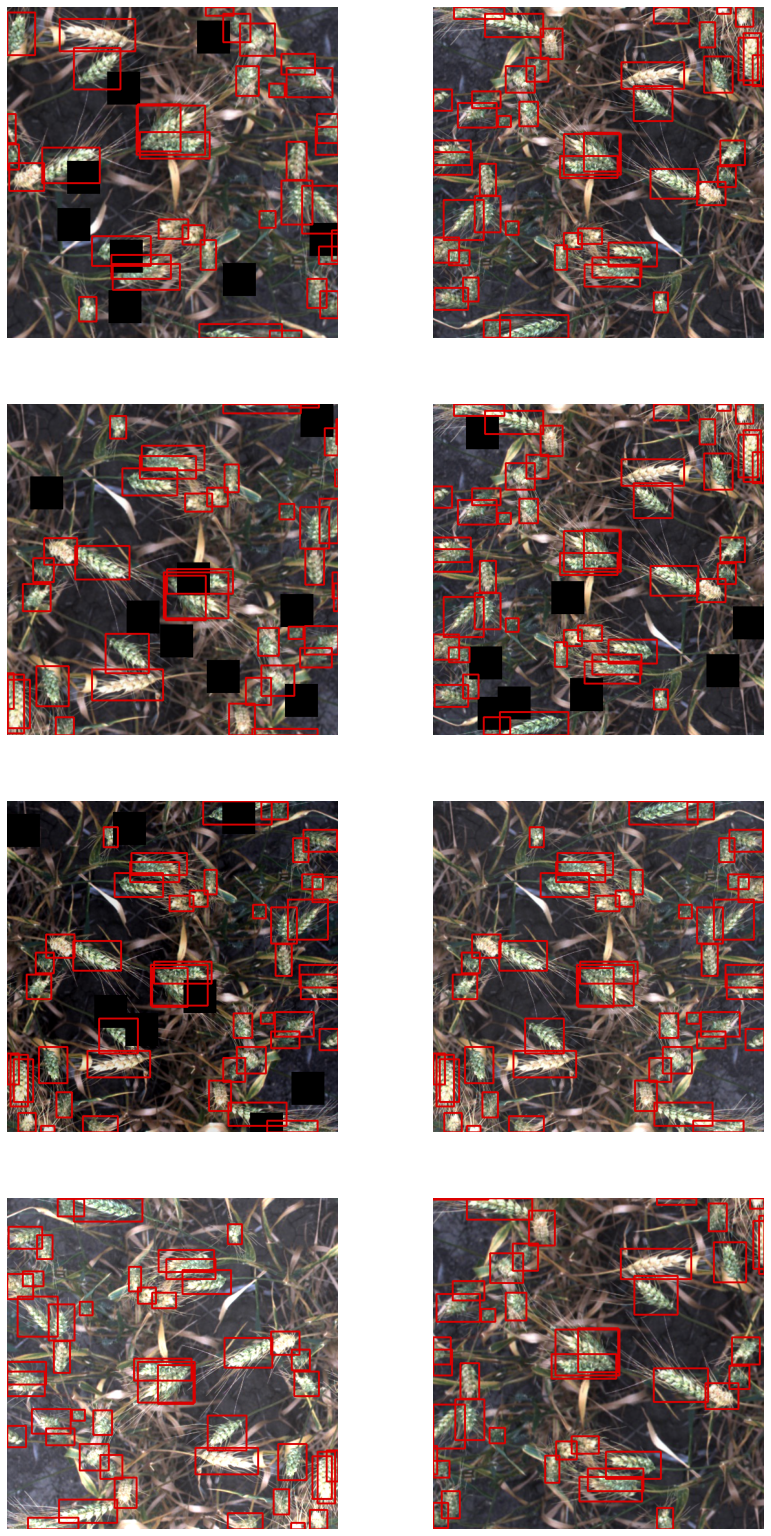

In [6]:
IDX = 1
_, ax = plt.subplots(4, 2, figsize=(14, 28))
for row in range(4):
    for col in range(2):
        img, target = dataset[IDX]
        img = img.transpose(1,2,0).copy()
        for i in range(len(target["bbox"])):
            box = target["bbox"][i, (1, 0, 3, 2)].round().astype(int) 
            _ = cv2.rectangle(
                img,
                (box[0], box[1]),
                (box[2], box[3]),
                (220, 0, 0), 2)
        ax[row][col].axis('off')
        ax[row][col].imshow(img)

### Mosaic
References:
1. [ultralytics/yolov5](https://github.com/ultralytics/yolov5/blob/831773f5a23926658ee76459ce37550643432123/utils/datasets.py#L529)
2. [shonenkov/training-efficientdet](https://www.kaggle.com/shonenkov/training-efficientdet)

In [7]:
dataset = WheatDataset(
    df=df, image_dir="../data/512/train/", 
    transforms=get_train_transforms(image_size=512, cutout=False),
    mosaic_p=1.0
)

[RandomSizedCrop(always_apply=False, p=0.5, min_max_height=(409, 512), height=512, width=512, w2h_ratio=1.0, interpolation=1), OneOf([
  HueSaturationValue(always_apply=False, p=0.9, hue_shift_limit=(-0.2, 0.2), sat_shift_limit=(-0.2, 0.2), val_shift_limit=(-0.2, 0.2)),
  RandomBrightnessContrast(always_apply=False, p=0.9, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=0.9), HorizontalFlip(always_apply=False, p=0.5), VerticalFlip(always_apply=False, p=0.5)]


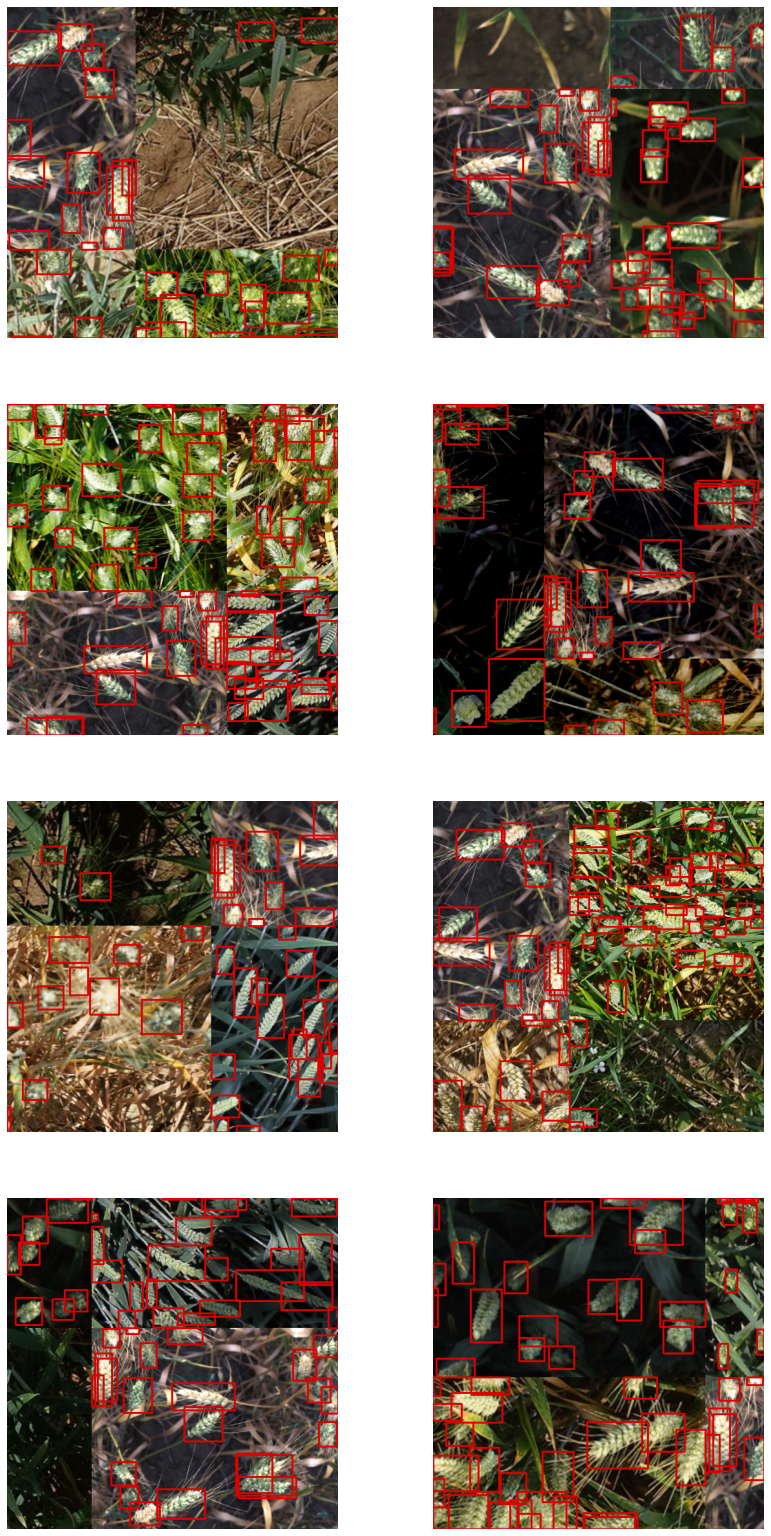

In [8]:
IDX = 1
_, ax = plt.subplots(4, 2, figsize=(14, 28))
for row in range(4):
    for col in range(2):
        img, target = dataset[IDX]
        img = img.transpose(1,2,0).copy()
        for i in range(len(target["bbox"])):
            box = target["bbox"][i, (1, 0, 3, 2)].round().astype(int) 
            _ = cv2.rectangle(
                img,
                (box[0], box[1]),
                (box[2], box[3]),
                (220, 0, 0), 2)
        ax[row][col].axis('off')
        ax[row][col].imshow(img)